## Step 1: Prepare Project

In [1]:
# Pandas for managing datasets
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import operator
from numpy import set_printoptions
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_mldata
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import ExtraTreesClassifier
from collections import Counter

In [2]:
mnist = fetch_mldata('MNIST original', data_home='.')
names=np.array(['pixel'+str(x).zfill(3) for x in range(0,784)])
names_dict={'pixel'+str(x).zfill(3):x for x in range(0,784)}

In [3]:
mnist_pd = pd.DataFrame(mnist.data,columns=names)
mnist_pd['label'] = mnist.target
mnist_pd['label'] = mnist_pd['label'].apply(lambda i: str(i))

## Step 2: Define Problem
Our task is to find the best algorithm for classification of mnist dataset.It contains 70000 images that are represented in a 28 * 28 grid.It also contains the labels that represent the actual value of the image.


## Step 3: Exploratory Analysis

Below,we find the shape of the mnist dataset.It contains 70000 pictures with an 28 * 28 array that contains the pixels of the image.The target variable is the numerical representation of the image

In [4]:
print "Head :\n", mnist_pd.head()
print "------------------------------------------------------------------------------------------------"
print "Tail :", mnist_pd.tail()

Head :
   pixel000  pixel001  pixel002  pixel003  pixel004  pixel005  pixel006  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   pixel007  pixel008  pixel009  ...    pixel775  pixel776  pixel777  \
0         0         0         0  ...           0         0         0   
1         0         0         0  ...           0         0         0   
2         0         0         0  ...           0         0         0   
3         0         0         0  ...           0         0         0   
4         0         0         0  ...           0         0         0   

   pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  label  
0         0         0         0       

In [5]:
(data_count,label_count) = mnist.data.shape
print "Number of data points:",data_count
print "Number of labels:",label_count

Number of data points: 70000
Number of labels: 784


Below we check if the dataset contains any null values,the value type of the pixels and the available classes.NULL values can have a negative effect on our classifier.The classes represent the numbers (0-9) that the image shows. 

In [6]:
print 'Are there any null values? ',mnist_pd.isnull().values.any()
print "Type of the columns:",set(mnist_pd.dtypes)
print "Classes to classify the data: ",set(mnist.target)

Are there any null values?  False
Type of the columns: set([dtype('O'), dtype('uint8')])
Classes to classify the data:  set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])


As a pre-processing step either for further processing or visualisation we decompose raw data into their principal components using Principal Component Analysis (PCA). This allows us to reduce the dimensionality of the data while retaining as much of their original variance as possible.I am going to use the PCA in order to represent the points in a scatter plot.

In [7]:
pca = PCA(n_components=2)
data2d=pca.fit_transform(mnist.data)
#print"Variance data2dNoScale:" ,(pca.explained_variance_)
print "PCA reduced dimension:",data2d.shape
print "Actual data dimension:",mnist.data.shape

PCA reduced dimension: (70000, 2)
Actual data dimension: (70000, 784)


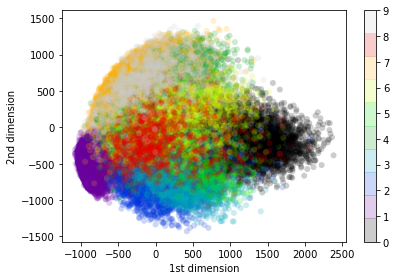

In [8]:
plt.scatter(data2d[:, 0], data2d[:, 1],c=mnist.target, edgecolor='none', alpha=0.2,cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.colorbar()
plt.tight_layout()
plt.show()

### describe() returns 8 statistical properties for each attribute

    Count: how many values the attribute has
    Mean: the mean of all values of the attribute
    Standard Deviation: the amount of variation values have. Low $\sigma$ means values are closer to the mean
    Minimum value
    25th Percentile: the value under which 25% of the instances can be found
    50th Percentile: the value under which 50% of the instances can be found (also called the median, is the value that splits the distribution in half)
    75th Percentile: the value under which 75% of the instances can be found
    Maximum value

In [9]:
print (mnist_pd.describe())

       pixel000  pixel001  pixel002  pixel003  pixel004  pixel005  pixel006  \
count   70000.0   70000.0   70000.0   70000.0   70000.0   70000.0   70000.0   
mean        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
std         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
min         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
25%         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
50%         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
75%         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
max         0.0       0.0       0.0       0.0       0.0       0.0       0.0   

       pixel007  pixel008  pixel009    ...         pixel774      pixel775  \
count   70000.0   70000.0   70000.0    ...     70000.000000  70000.000000   
mean        0.0       0.0       0.0    ...         0.197414      0.099543   
std         0.0       0.0       0.0    ...         5.9912

In order to summarise distribution of instances across classes on classification problems you need to know how the data are distributed among the classes.Highly imbalanced problems (a lot more observations for one class than another) are common and they need a different approach as far as data preparation is concerned.As we can see the data are equally distributed among the classes. 



In [10]:
print(mnist_pd.groupby('label').size())

label
0.0    6903
1.0    7877
2.0    6990
3.0    7141
4.0    6824
5.0    6313
6.0    6876
7.0    7293
8.0    6825
9.0    6958
dtype: int64


### Histogram
To visualize that the data are equally distributed among the classes:

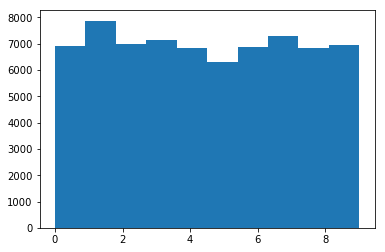

In [11]:
plt.hist(mnist.target)
plt.show()


### Box Plot


Box plot can be summarised to the following:
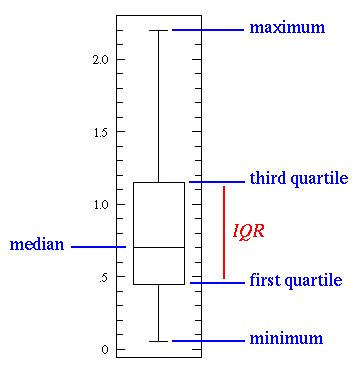

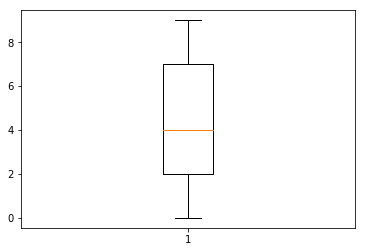

In [12]:
plt.boxplot(mnist.target)
plt.show()

## Step 4: Prepare Data

### Rescale Data
Rescaling data is multiplying each member of a data set by a constant.The rescaled data have a value between 0 and 1.Rescaling will change the spread of your data as well as the position of your data points. What remains unchanged is the shape of distribution and the relative attributes of our curve. 

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
mnist.data = scaler.fit_transform(mnist.data)
set_printoptions(precision=3)
print(mnist.data[0:5,:])

/home/mscuser/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


### Standardise Data
A standardized value is what you get when you take a data point and scale it by population data.

In [14]:
scaler = StandardScaler().fit(mnist.data)
mnist.data = scaler.transform(mnist.data)
# summarise transformed data
set_printoptions(precision=3)
print(mnist.data[0:5,:])

print 'Scaled data mean is:',np.mean(mnist.data)
print 'Scaled data variance is:',np.var(mnist.data)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Scaled data mean is: 5.55118199545e-14
Scaled data variance is: 0.917091836735


### Normalise Data

In [15]:
scaler = Normalizer().fit(mnist.data)
mnist.data= Normalizer().transform(mnist.data)
print(mnist.data[0:5,:])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


## Step 5: Feature Engineering

A feature is an attribute or property shared by all of the independent units on which analysis or prediction is to be done. Any attribute could be a feature, as long as it is useful to the model. The purpose of a feature, other than being an attribute, would be much easier to understand in the context of a problem. A feature is a characteristic that might help when solving the problem. The features in our data are important to the predictive models you use and will influence the results we are going to achieve. The quality and quantity of the features will have great influence on whether the model is good or not.You could say the better the features are, the better the result is. This isn't entirely true, because the results achieved also depend on the model and the data, not just the chosen features. That said, choosing the right features is still very important. Better features can produce simpler and more flexible models, and they often yield better results

## Feature Selection and Feature reduction
For feature selection I chose to remove the features that have zero correlation with the target variable or those that their variance is low.
For feature reduction I chose to perform pca analysis keeping 10 of the reduced features.For more dimensions the algorithms needed exceptional amount of time.

In [16]:
delIndices=[]
X=mnist.data
Y=mnist.target
col_names=names
col_dict=dict(names_dict)

for i in range(0,(X.shape[1])):
    if np.correlate(X[:,i],Y[:])[0]==0 or np.var(X[:,i])<10**(-4):
        delIndices.append(i)
counter=0
for x in delIndices:
    X=np.delete(X,np.s_[x-counter],1)
    del col_dict[col_names[x-counter]]
    col_names=np.delete(col_names,x-counter)
    col_dict.update((k, v-1) for k,v in col_dict.items() if v>x-counter)
    counter+=1

In [19]:
model = ExtraTreesClassifier()
XET=X
YET=Y
col_names_=col_names
col_dict_=dict(col_dict)
model.fit(XET, YET)
zipped=zip(col_names_, model.feature_importances_)
zipped=sorted(zipped,key = lambda t: t[0])
mean_values=np.array([y for x,y in zipped])
mean_value=mean_values.mean()
print mean_value
counter=0
for x,y in zipped:
    if y<mean_value:
        pos=col_dict_[x]
        XET=np.delete(XET,np.s_[pos],1)
        del col_dict_[x]
        col_names_=np.delete(col_names_,pos)
        col_dict_.update((k, v-1) for k,v in col_dict_.items() if v>pos)
print 'Removed features with names:',list(set(names).symmetric_difference(col_names_))
GUWOP=XET

0.0016
Removed features with names: ['pixel389', 'pixel145', 'pixel147', 'pixel141', 'pixel229', 'pixel143', 'pixel142', 'pixel224', 'pixel225', 'pixel226', 'pixel227', 'pixel220', 'pixel221', 'pixel222', 'pixel223', 'pixel688', 'pixel709', 'pixel708', 'pixel707', 'pixel706', 'pixel705', 'pixel704', 'pixel703', 'pixel702', 'pixel701', 'pixel700', 'pixel039', 'pixel038', 'pixel031', 'pixel030', 'pixel033', 'pixel032', 'pixel035', 'pixel034', 'pixel037', 'pixel036', 'pixel130', 'pixel131', 'pixel132', 'pixel133', 'pixel134', 'pixel135', 'pixel137', 'pixel138', 'pixel139', 'pixel684', 'pixel685', 'pixel682', 'pixel529', 'pixel528', 'pixel044', 'pixel042', 'pixel014', 'pixel452', 'pixel451', 'pixel450', 'pixel455', 'pixel123', 'pixel144', 'pixel122', 'pixel121', 'pixel692', 'pixel127', 'pixel694', 'pixel125', 'pixel696', 'pixel282', 'pixel283', 'pixel129', 'pixel128', 'pixel776', 'pixel777', 'pixel774', 'pixel775', 'pixel772', 'pixel773', 'pixel770', 'pixel771', 'pixel079', 'pixel778', 'pi

In [20]:
XET=GUWOP
pca = PCA(n_components=10)
XET= pca.fit_transform(XET)
print 'Shape after',XET.shape

Shape after (70000, 10)


## Step 6: Algorithm Selection
Below we execute a number of algorithms and print their mean estimated accuracy.

### Algorithm Selection/Algorithm Comparison
K-Folds cross-validator.
Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

In [21]:
models={}
ensembles={}
xTr, xTe, yTr, yTe = train_test_split(XET, YET, test_size=0.2)
kfold = KFold(n_splits=10, random_state=7)
mean_scores={}
scores={}
algos={}

We are going to compare a set of algorithms:

    Logistic Regression
    Linear Discriminant Analysis
    k-Nearest Neighbors
    Decision Trees
    Naive Bayes

In [22]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models1 = {}
models1['LRS']=LogisticRegression()
models1["LDAS"]=LinearDiscriminantAnalysis()
models1["kNNS"]=KNeighborsClassifier()
models1["DTS"]=DecisionTreeClassifier()
models1["NBS"]=GaussianNB()

The scoring function to use:

In [23]:
scoring = 'accuracy'

We are going to evaluate all classifiers using kfold and scoring accuracy and store results in two lists:

In [24]:
results = []
kfold = KFold(n_splits=10, random_state=7)
for ind, name in enumerate(models1):
  cv_results = cross_val_score(models1[name], xTr, yTr, cv=kfold, scoring=scoring)
  scores[name]=cv_results
  mean_scores[name]=cv_results.mean()
  print("%010s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))
models=models1
algos=models1

       DTS: 0.810518 (+/- 0.008619)
       NBS: 0.787893 (+/- 0.005661)
       LRS: 0.779125 (+/- 0.006242)


/home/mscuser/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


      LDAS: 0.777143 (+/- 0.004040)
      kNNS: 0.921518 (+/- 0.002784)


## Step 7: Model Training
Apply ensembles and improve performance by hyperparameter optimisation.

### Python scikit-learn provides a simple method for algorithm parameter tuning:
Grid Search


### Decision Tree Classifier with parameter tuning
<h4>max_features</h4>
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
<h4>splitter</h4>
The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.
<h4>max_depth</h4>
The maximum depth of the tree


In [25]:
parameters = {'criterion': ['gini','entropy'],
          'splitter': ['best','random'], 
          'max_depth':[x for x in range(1,15)]}

Create and fit a decision tree classifier model, testing each parameter:

In [26]:
model=DecisionTreeClassifier()
models["DT"] = GridSearchCV(model, param_grid=parameters)
#Learning
models["DT"].fit(xTr,yTr)
print("Best Hyper Parameters:",models["DT"].best_params_)
algos["DT"] = DecisionTreeClassifier(criterion=models["DT"].best_params_["criterion"],
                             splitter=models["DT"].best_params_["splitter"],
                                     max_depth=models["DT"].best_params_["max_depth"])
ensembles['DT']=algos["DT"]
scores["DT"] = cross_val_score(algos["DT"], xTr, yTr, cv=kfold, scoring=scoring)
mean_scores["DT"]=scores["DT"].mean()
print scores["DT"]
print mean_scores["DT"]


('Best Hyper Parameters:', {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 14})
[ 0.818  0.822  0.825  0.821  0.821  0.827  0.827  0.822  0.815  0.829]
0.822589285714


### Logistic Regression with parameter tuning
<h4>solver_options</h4>
default: ‘liblinear’ Algorithm to use in the optimization problem.
    For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and
        ‘saga’ are faster for large ones.
    For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
        handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas
        ‘liblinear’ and ‘saga’ handle L1 penalty.
<h4>multi_class_options</h4>
Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution
<h4>class_weight_options</h4>
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.


In [27]:
solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
multi_class_options = ['ovr']
class_weight_options = [None,'balanced']

parameters = dict(solver = solver_options, multi_class = 
multi_class_options, class_weight = class_weight_options)

In [28]:
model=LogisticRegression()
models["LR"] = GridSearchCV(model, param_grid=parameters)
#Learning
models["LR"].fit(xTr,yTr)
print("Best Hyper Parameters:",models["LR"].best_params_)
algos["LR"] = LogisticRegression(solver=models["LR"].best_params_["solver"],
                             multi_class=models["LR"].best_params_["multi_class"],
                             class_weight=models["LR"].best_params_["class_weight"])
ensembles['LR']=algos["LR"]
scores["LR"] = cross_val_score(algos["LR"], xTr, yTr, cv=kfold, scoring=scoring)
mean_scores["LR"]=scores["LR"].mean()
print scores["LR"]
print mean_scores["LR"]

/home/mscuser/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


('Best Hyper Parameters:', {'multi_class': 'ovr', 'solver': 'lbfgs', 'class_weight': 'balanced'})
[ 0.77   0.782  0.777  0.784  0.786  0.78   0.787  0.784  0.771  0.781]
0.780035714286


### Linear Discriminant Analysis with parameter tuning
<h4>solver</h4>
Solver to use, possible values:
    ‘svd’: Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.
    ‘lsqr’: Least squares solution, can be combined with shrinkage.
    ‘eigen’: Eigenvalue decomposition, can be combined with shrinkage.
<h4>n_components</h4>
Number of components (< n_classes - 1) for dimensionality reduction.


In [29]:
 parameters = {'solver' : ['svd','lsqr' ,'eigen'],
        'n_components' : [2,3,4,5,6,7,8,9,10,11,12]}

In [30]:
model=LinearDiscriminantAnalysis()
models["LDA"] = GridSearchCV(model, param_grid=parameters)
#Learning
models["LDA"].fit(xTr,yTr)
print("Best Hyper Parameters:",models["LDA"].best_params_)
algos["LDA"] = LinearDiscriminantAnalysis(solver=models["LDA"].best_params_["solver"],
                             n_components=models["LDA"].best_params_["n_components"])
scores["LDA"] = cross_val_score(algos["LDA"], xTr, yTr, cv=kfold, scoring=scoring)
ensembles['LDA']=algos["LDA"]
mean_scores["LDA"]=scores["LDA"].mean()
print scores["LDA"]
print mean_scores["LDA"]


('Best Hyper Parameters:', {'n_components': 2, 'solver': 'svd'})
[ 0.772  0.777  0.772  0.778  0.782  0.779  0.785  0.776  0.773  0.777]
0.777142857143


### KNeighborsClassifier with parameter tuning
<h4>n_neighbors</h4>
Number of neighbors to use by default for kneighbors queries.
<h4>weights</h4>
weight function used in prediction. Possible values:
        ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
        ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
        [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.





In [31]:
neighbors = [x for x in range(5,21,5)]
parameters = {'n_neighbors': neighbors}

In [32]:
model=KNeighborsClassifier()
models["kNN"] = GridSearchCV(model, param_grid=parameters)
#Learning
models["kNN"].fit(xTr,yTr)
print("Best Hyper Parameters:",models["kNN"].best_params_)
algos["kNN"] = KNeighborsClassifier(
        n_neighbors=models["kNN"].best_params_['n_neighbors'])
ensembles['kNN']=algos["kNN"]
scores["kNN"] = cross_val_score(algos["kNN"], xTr, yTr, cv=kfold, scoring=scoring)
mean_scores["kNN"]=scores["kNN"].mean()
print scores["kNN"]
print mean_scores["kNN"]

('Best Hyper Parameters:', {'n_neighbors': 5})
[ 0.919  0.917  0.923  0.924  0.919  0.926  0.919  0.92   0.922  0.925]
0.921517857143


Due to the fact that agglomerative cannot be grid searched,as it requires a specific implemented scoring function,I implementented and performed the algorithm on a smaller subset of the data.

### Agglomerative Hierarchical Clustering
<h4>linkage</h4>
Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

        ward minimizes the variance of the clusters being merged.
        average uses the average of the distances of each observation of the two sets.
        complete or maximum linkage uses the maximum distances between all observations of the two sets.
<h4>n_clusters</h4>
The number of clusters to find.

In [33]:
def clustering_acc(clustering, labels):
    """Measure the overall accuracy of the given `clustering` given the `labels`"""
    cluster=[]
    acc_cluster=[]
    for i in range(10):
        cluster.append([])
        acc_cluster.append([])
    counter=0
    for cl in clustering:
        cluster[cl].append(int(labels[counter]))
        counter+=1
    counter=0
    total_acc=0.0
    for i in range(10):
        temp=Counter(cluster[i])
        total_acc+=float(max(temp.iteritems(), key=operator.itemgetter(1))[1])/float(len(cluster[i]))
    return total_acc/10.0

In [34]:
ward_cluster = AgglomerativeClustering(n_clusters =10,linkage ="ward")
ward_cluster.fit(xTr[0:1000])
ward_clustering= ward_cluster.fit_predict(xTr[0:1000])

comp_cluster =AgglomerativeClustering(n_clusters =10,linkage ="complete")
comp_cluster.fit(xTr[0:1000])
comp_clustering= comp_cluster.fit_predict(xTr[0:1000])

avg_cluster = AgglomerativeClustering(n_clusters =10,linkage ="average")
avg_cluster.fit(xTr[0:1000])
avg_clustering= avg_cluster.fit_predict(xTr[0:1000])




acc_ward = clustering_acc(ward_clustering, yTr)
acc_comp = clustering_acc(comp_clustering, yTr)
acc_avg= clustering_acc(avg_clustering, yTr)
    
print 'Ward\'s method:', acc_ward
print 'Complete link:', acc_comp
print 'Average link: ', acc_avg

Ward's method: 0.694894983269
Complete link: 0.591899448565
Average link:  0.690077788181


### Voting

In [35]:
votingList=[]
print ensembles
for key,value in ensembles.items():
    votingList.append((key,value))
algos["VOT"] = VotingClassifier(votingList)
scores['VOT'] = cross_val_score(algos["VOT"], xTr, yTr, cv=kfold)
mean_scores["VOT"]=scores["VOT"].mean()

print scores["VOT"]
print mean_scores["VOT"]


{'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), 'DT': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'LR': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), 'LDA': LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)}
[ 0.832  0.837  0.842  0.843  0.849  0.842  0.848  

### ADABoost
Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms which convert weak learners to strong ones 

<h4>n_estimators</h4>
The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.

In [37]:

algos["ADB"] = AdaBoostClassifier(n_estimators=256)
scores["ADB"] = cross_val_score(algos["ADB"], xTr, yTr, cv=kfold, scoring='accuracy')
mean_scores["ADB"]=scores["ADB"].mean()
print scores["ADB"]
print mean_scores["ADB"]

[ 0.595  0.585  0.585  0.562  0.599  0.561  0.566  0.563  0.578  0.587]
0.578160714286


### Random Forest
Random forest is a bagging algorithm.Random forests train a large number of “strong” decision trees and combine their predictions through bagging.
<h4>n_estimators</h4>
The number of trees in the forest.
<h4>max_depth</h4>
The maximum depth of the tree. 
<h4>max_features</h4>
The number of features to consider when looking for the best split.

In [38]:
algos["RDT"] = RandomForestClassifier(n_estimators=256,
                                     max_depth=12,
                                     max_features='log2')
scores["RDT"] = cross_val_score(algos["RDT"], xTr, yTr, cv=kfold, scoring='accuracy')
mean_scores["RDT"]=scores["RDT"].mean()
print scores["RDT"]
print mean_scores["RDT"]

[ 0.873  0.881  0.877  0.881  0.882  0.885  0.881  0.877  0.873  0.885]
0.879339285714


### Algorithm Comparison

In [39]:
sorted_acc = sorted(mean_scores.items(), key=operator.itemgetter(1))
print "Best algorithm with accuracy",sorted_acc[len(sorted_acc)-1]
print sorted_acc

Best algorithm with accuracy ('kNNS', 0.92151785714285739)
[('ADB', 0.57816071428571425), ('LDA', 0.77714285714285714), ('LDAS', 0.77714285714285714), ('LRS', 0.77912500000000007), ('LR', 0.78003571428571417), ('NBS', 0.78789285714285717), ('DTS', 0.81051785714285707), ('DT', 0.8225892857142858), ('VOT', 0.84007142857142869), ('RDT', 0.87933928571428566), ('kNN', 0.92151785714285739), ('kNNS', 0.92151785714285739)]


## Step 8: Finalise Model
Predictions on validation set, create model from the entire (training) dataset.

In [40]:
algos[sorted_acc[len(sorted_acc)-1][0]].fit(xTr,yTr)
predictions=algos[sorted_acc[len(sorted_acc)-1][0]].predict(xTe)
accuracy = cross_val_score(algos[sorted_acc[len(sorted_acc)-1][0]], xTe, yTe, cv=kfold, scoring='accuracy').mean()
print "Best algorithm selected:",sorted_acc[len(sorted_acc)-1][0],' with accuracy:',accuracy

Best algorithm selected: kNNS  with accuracy: 0.900642857143


## Step 9: Evaluation

Confusion matrix is metric of accuracy. The diagonal elements at the confusion matrix are the number of data that the best algorithm correctly predicted the target, while the rest are those that are not classified correctly. 

In [41]:
print "\nconfusion_matrix:\n",(confusion_matrix(yTe, predictions))


confusion_matrix:
[[1354    0    5    0    2   17   15    1    1    1]
 [   2 1571    9    4    0    1    1    3    0    2]
 [   9    5 1268    9   11    8   16   24   14    4]
 [   1    4   26 1301    1   26    0   19   33   10]
 [   0    4   19    3 1188   10   31    7   10   86]
 [   3    3    8   31    7 1173   22    9   13    8]
 [   9    4    7    1    2   12 1361    2    2    1]
 [   4    3   28    2    7    4    0 1384    4   25]
 [   5    9   31   76   13   46   11    9 1136   23]
 [   9    2    4   24   56   24   11   44   26 1166]]


Clasification Report is also a metric for the classification model.
    tp:number of true positives
    fp:number of false positives
    fn:number of false negatives
    precision:tp / (tp + fp) and measures the ability of the algorithm not to classify positively a label that is negative
    recall:ratio tp / (tp + fn) and measures the ability of the algorithm to find all the positive samples

In [42]:
print "\nclassification_report:\n", (classification_report(yTe, predictions))


classification_report:
             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97      1396
        1.0       0.98      0.99      0.98      1593
        2.0       0.90      0.93      0.91      1368
        3.0       0.90      0.92      0.91      1421
        4.0       0.92      0.87      0.90      1358
        5.0       0.89      0.92      0.90      1277
        6.0       0.93      0.97      0.95      1401
        7.0       0.92      0.95      0.93      1461
        8.0       0.92      0.84      0.87      1359
        9.0       0.88      0.85      0.87      1366

avg / total       0.92      0.92      0.92     14000



### Summary/Report
        As a summary, I first begun by fetching the mnist data and creating the names of the features.The data had a shape of (70000,748),which means that the dataset contained 70.000 images along with  28 * 28 array representing the pixels of the image.Each pixel was a different feature ,named as pixelXXX where XXX indicated the actual position of the pixel.We also defined the problem,which is the classification of the 70.000 images that represent one number from 0-9 into the appropriate class.
        At step 3,I began to explore our data. I printed the shape,and we performed various operations such as checking for null values(can have a significant effect on the conclusions that can be drawn from the data),finding the data type of the features(integers),the possible values that the target variable can take(0-9),dimensional reduction on the dataset to represent it in a 2d graph,description of  the dataset(returns 8 statistical properties for each attribute),the number of data that belong to the classes(highly imbalanced problems can lead to wrong models) among with visual representation(histogram and box plot) of the data distributions.As we can safely summarise from the above,is that the numerical values of the dataset do make sense because the refer to colour value for each pixel and that the data are equally distributed among the classes.
        At step 4,I performed data wrangling.Data wrangling is used to convert the raw data into the format that is convenient for the consumption of data.Rescaled,standarise and normalise were the basic data wrangling techniques that were performed.
        Feature selection was the next step.Feature selection is a very important process while preprocessing the data as its main role is to reduce the curse of dimensionality as much as possible.For feature selection I chose to remove the features that have zero correlation with the target variable(does not affect the predicted class) or those that their variance is low. Feature reduction is the process where  it uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.I chose to perform pca analysis keeping 10 of the reduced features.
        Next step was the algorithm selection.I chose to execute models without parameters(hyperparameter tuning will follow).Firstly,i should split the test and train set into 80% train-20.I chose to execute the following algorithms:
        Logistic Regression
        Linear Discriminant Analysis
        k-Nearest Neighbors
        Decision Trees
        Naive Bayes
        I compared and stored the models in a dictionary in order to compare all the algorithms.
        Afterwards,I performed model training.I tried to improve the accuracy of the 5 algorithms selected above by performing hyperparameter tuning,eg trying to find the best values for the parameters to maximize the accuracy.I also decided to include the agglomerative model in a smaller subset of the data(10000-as the fit method seems to not work with the full dataset) and with my own accuracy function(get the maximum class appearance per cluster and assign this cluster to this class,rest of observations are incorrectly classified).In addition,the simple voting algorithm was selected. It is one of the simplest ways of combining the predictions from multiple machine learning algorithms.Also,adaboost,which is a boosting algorithm(general learning approach for constructing a strong learner, given a collection of (possibly infinite) weak learners) and Random Forest,which is a bagging algorithm(an attempt to reduce the chance overfitting complex models) are performed.All mean scores,accuracies,algorithms are stored in a dictionary where we will finally find which algorithm produced the best accuracy of all the algorithms.This algorithm will be run with the test subset of the data.
        Now, I have to test the best algorithm with the test data.After the evaluation, we have to perform various metrics to find how good the algorithm was. I chose two metrics:
        i)Confusion matrix
        ii)Classification report
        A confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm.Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).[2] The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabelling one as another).It is a special kind of contingency table, with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table).
        The classification report consists the following:
        a)The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
        b)The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
        c)The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall.
        